In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We'll be doing a classic survival analysis model, using Cox PH to look at sex differences in time to death (aka. longevity) using data from the [U.S.  National Health Interview Survey](https://ihis.ipums.org/).  This data is particularly great because they have both year of birth and year of death.  Death records stop in 2009 (when the dataset was considered complete), so any people who are still living in 2009 will need to be right-censored.

Some people do not have date of birth.  Those cases will be truncated.  

Let's start by loading the data, taking a look at it, and cleaning it up:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/nhis.csv")



In [3]:
data.head()

,Unnamed: 0,YEAR,NHISPID,AGE,SEX,SEXORIEN,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY
0,2744230,1986,1986109602890101,60,1,NaN,11,NaN,1.0,2005.0
1,2744231,1986,1986109602890102,54,2,NaN,11,NaN,1.0,2010.0
2,2744232,1986,1986109602890103,21,1,NaN,50,NaN,2.0,9999.0
3,2744233,1986,1986109602890201,46,1,NaN,11,NaN,2.0,9999.0
4,2744234,1986,1986109602890202,38,2,NaN,11,NaN,2.0,9999.0


In [7]:
data.AGE.value_counts()

40    35100
36    34876
35    34871
33    34702
34    34600
      ...  
95      185
96      156
99      121
97       82
98       66
Name: AGE, Length: 82, dtype: int64

In [8]:
data.BIRTHYR.value_counts()

1960.0    16640
1962.0    16304
1961.0    16118
1964.0    16105
1957.0    16062
          ...  
1990.0     1518
1913.0     1359
1991.0      779
9998.0      205
1992.0        2
Name: BIRTHYR, Length: 83, dtype: int64

In [9]:
data.BIRTHYR.min()

1913.0

In [10]:
data.BIRTHYR.max()

9999.0

In [11]:
9999.0-1913.0


8086.0

In [12]:
data.tail()

,Unnamed: 0,YEAR,NHISPID,AGE,SEX,SEXORIEN,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY
1605241,5121672,2009,20090641040103,29,1,NaN,10,1980.0,2.0,9999.0
1605242,5121673,2009,20090641040104,27,1,NaN,10,1982.0,2.0,9999.0
1605243,5121674,2009,20090641040105,19,1,NaN,50,1990.0,2.0,9999.0
1605244,5121675,2009,20090641040106,25,1,NaN,50,1984.0,2.0,9999.0
1605245,5121677,2009,20090641050101,55,2,NaN,30,1954.0,2.0,9999.0


In [13]:
data.shape

(1605246, 10)

In [14]:
data.shape

(1605246, 10)

In [15]:
data.isnull().sum()

Unnamed: 0          0
YEAR                0
NHISPID             0
AGE                 0
SEX                 0
SEXORIEN      1605246
MARSTAT             0
BIRTHYR        829402
MORTSTAT            0
MORTDODY            0
dtype: int64

In [16]:
# remove a single column (axis=1 refers to columns)
data.drop('SEXORIEN', axis = 1, inplace = True)

In [17]:
data.describe()

,Unnamed: 0,YEAR,NHISPID,AGE,SEX,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY
count,1.605246e+06,1.605246e+06,1.605246e+06,1.605246e+06,1.605246e+06,1.605246e+06,775844.000000,1.605246e+06,1.605246e+06
mean,3.912783e+06,1.996629e+03,1.038483e+15,4.480116e+01,1.532664e+00,2.224264e+01,2181.119822,1.834448e+00,8.675186e+03
std,6.910911e+05,6.812085e+00,9.850259e+14,1.756692e+01,4.989321e-01,1.663380e+01,1323.690066,3.716777e-01,2.972078e+03
min,2.744230e+06,1.986000e+03,1.997000e+13,1.800000e+01,1.000000e+00,1.000000e+01,1913.000000,1.000000e+00,1.986000e+03
25%,3.310076e+06,1.991000e+03,2.003023e+13,3.100000e+01,1.000000e+00,1.100000e+01,1946.000000,2.000000e+00,9.999000e+03
50%,3.889598e+06,1.996000e+03,1.986344e+15,4.200000e+01,2.000000e+00,1.100000e+01,1959.000000,2.000000e+00,9.999000e+03
75%,4.511346e+06,2.002000e+03,1.991305e+15,5.700000e+01,2.000000e+00,3.000000e+01,1972.000000,2.000000e+00,9.999000e+03
max,5.121677e+06,2.009000e+03,1.996359e+15,9.900000e+01,2.000000e+00,9.900000e+01,9999.000000,2.000000e+00,9.999000e+03


In [ ]:
data.columns

In [19]:

# Dropping cases where birth year is not known
data2 =data[(data["BIRTHYR"]<=2009) & (data["BIRTHYR"].notnull())]

# Calculating time-to-event
data2["Longevity"]= data2["MORTDODY"] - data2["BIRTHYR"]

# Creating a 'status' variable where 1 means dead and 0 means alive as of 2009
data2["dead"]=2-data2['MORTSTAT']

# For people who were alive as of 2009, calculating their longevity as their age in 2009
data2.loc[data2['dead']==0,"Longevity"] = 2009 -data2.loc[data2['dead']==0,"BIRTHYR"] 

# Creating a binary variable where 1 = female and 0 = male
data2["female"] = (data2["SEX"] == 2).astype(int)


C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [20]:
data2.dtypes

Unnamed: 0      int64
YEAR            int64
NHISPID         int64
AGE             int64
SEX             int64
MARSTAT         int64
BIRTHYR       float64
MORTSTAT      float64
MORTDODY      float64
Longevity     float64
dead          float64
female          int32
dtype: object

In [23]:
data2.loc[data2['dead']==0,"Longevity"] 

829402     46.0
829403     49.0
829405     65.0
829407     54.0
829408     49.0
           ... 
1605241    29.0
1605242    27.0
1605243    19.0
1605244    25.0
1605245    55.0
Name: Longevity, Length: 686836, dtype: float64

In [22]:
data["BIRTHYR"].notnull()

0          False
1          False
2          False
3          False
4          False
           ...  
1605241     True
1605242     True
1605243     True
1605244     True
1605245     True
Name: BIRTHYR, Length: 1605246, dtype: bool

In [21]:
data2.shape

(754219, 12)

In [24]:
data2.isna().sum()

Unnamed: 0    0
YEAR          0
NHISPID       0
AGE           0
SEX           0
MARSTAT       0
BIRTHYR       0
MORTSTAT      0
MORTDODY      0
Longevity     0
dead          0
female        0
dtype: int64

In [25]:
data2.head()

,Unnamed: 0,YEAR,NHISPID,AGE,SEX,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY,Longevity,dead,female
829402,3928174,1997,19970003080101,33,2,11,1963.0,2.0,9999.0,46.0,0.0,1
829403,3928175,1997,19970003080102,36,1,11,1960.0,2.0,9999.0,49.0,0.0,0
829404,3928178,1997,19970003090101,42,1,11,1954.0,1.0,1999.0,45.0,1.0,0
829405,3928179,1997,19970003090102,52,2,11,1944.0,2.0,9999.0,65.0,0.0,1
829407,3928182,1997,19970003100101,41,1,11,1955.0,2.0,9999.0,54.0,0.0,0


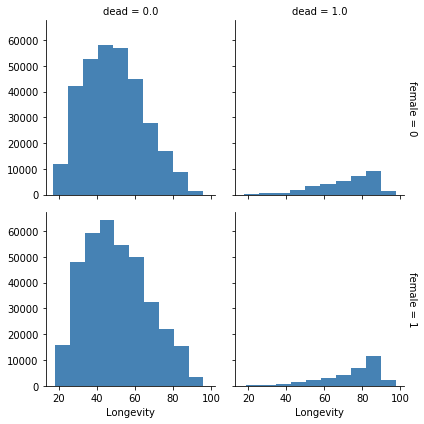

In [26]:
g = sns.FacetGrid(data2, row="female", col="dead",margin_titles=True)
g.map(plt.hist, "Longevity", color="steelblue", lw=0)
plt.show()

# The first look

After data cleaning, we've gone from 1605246 records to 1305561.  The vast majority of our sample was still living as of 2009.  This means most of our data will be right-censored.

Now we're going to use the `statsmodels` survival analysis functions to create some models for our data.  First, we can calculate the Hazard (risk of death) for each age, starting at the youngest people in the sample (18 years old in 2009). 

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

sf = sm.SurvfuncRight(data2["Longevity"], data2["dead"])
sf.summary().head()

,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
18.0,0.999997,0.000002,754217,2.0
19.0,0.999981,0.000005,753439,12.0
20.0,0.999940,0.000009,751911,31.0
21.0,0.999879,0.000013,749414,46.0
22.0,0.999825,0.000015,746169,40.0


You can notice a few things in the survival table: 
* First, only 2 people in the sample died at the age of 18, with the number of deaths increasing after that.
* Second, the standard error steadily gets larger as the sample size (the number at risk, aka. the number of people alive at that timepoint) shrinks.  
* Finally, the 'number at risk' drops at each timepoint, but by quite a bit more than the number of deaths.  This reflects our right-censoring.  If someone turned 18 in 2009 and didn't die, they don't count toward the 'number at risk' at age 19 because they're out of the observation window, but they also aren't an event at timepoint 18 because they were still alive at that age.

We can also make a very nice survival plot for the men and the women:

(0.85, 1)

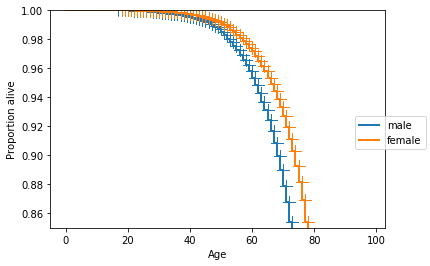

In [28]:
# Code for this plot modified from the statsmodels documentation at http://www.statsmodels.org/dev/duration.html

groups = data2.groupby("female")
ax = plt.axes()
sexes = ["male","female"]

# Fitting a survival function for each group
for group in groups:
    sf = sm.SurvfuncRight(group[1]["Longevity"], group[1]["dead"])
    sf.plot(ax)
li = ax.get_lines()
plt.figlegend((li[0], li[2]), sexes, "center right")
ax.set_ylabel("Proportion alive")
ax.set_xlabel("Age")
ax.set_autoscaley_on(False)
ax.set_ylim([.85,1])



In [32]:
groups = data2.groupby('female')
groups

Most people are still alive, but this may be due to extreme right-censoring.  

# Cox PH for gender

A graph is all very well, but is the difference in longevity for men and women meaningful?  We can test using the Cox PH model.

In [33]:
mod = smf.phreg("Longevity ~ female", # The model
                data2, # The data
                status=data2['dead'].values # Whether values are right-censored
                ) 
rslt = mod.fit()
rslt.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: PHReg
=============================================================
Model:                  PH Reg        Sample size:     754217
Dependent variable:     Longevity     Num. events:     67383 
Ties:                   Breslow                              
-------------------------------------------------------------
        log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
-------------------------------------------------------------
female -0.4460    0.0078 0.6402 -57.5296 0.0000 0.6306 0.6500
=============================================================
Confidence intervals are for the hazard ratios
"""

It looks like the difference is meaningful.  The convention is to report and interpret the Hazard Ratio (HR) rather than the log HR.  According to the Cox PH, at any given age, women are 64% less likely to die than men, with a 95% confidence interval of 63% to 65%.  This difference is statistically significant at $\alpha$ of .05 (p < .0001).  Our confidence interval is tiny because our sample is so big!

Looking from the plot to the model, you may notice that the data tell a slightly different story.  The survival rate discrepancy seems to shrink a bit after age 80.  This suggests that either we should include some additional features in the model to try and account for this discrepancy, or we should use a different modeling technique that doesn't assume that the effects of features are consistent across all values.

We can plot the predicted survival rates from the model:

In [34]:
data3=data2[(data2['Longevity'].notnull()) & (data2['female'].notnull()) & (data2['dead'].notnull())]
data3["predicted"] = rslt.predict(pred_type='surv').predicted_values

data3.head()



,Unnamed: 0,YEAR,NHISPID,AGE,SEX,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY,Longevity,dead,female,predicted
829402,3928174,1997,19970003080101,33,2,11,1963.0,2.0,9999.0,46.0,0.0,1,0.994803
829403,3928175,1997,19970003080102,36,1,11,1960.0,2.0,9999.0,49.0,0.0,0,0.988401
829404,3928178,1997,19970003090101,42,1,11,1954.0,1.0,1999.0,45.0,1.0,0,0.992777
829405,3928179,1997,19970003090102,52,2,11,1944.0,2.0,9999.0,65.0,0.0,1,0.956459
829407,3928182,1997,19970003100101,41,1,11,1955.0,2.0,9999.0,54.0,0.0,0,0.978739


In [35]:
data3.shape

(754219, 13)

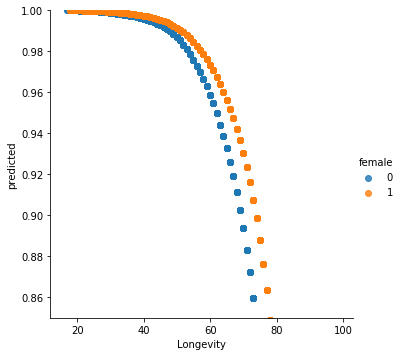

In [36]:
sns.lmplot(x="Longevity", y="predicted", hue="female", data=data3,fit_reg=False,lowess=True)
plt.ylim(.85, 1)
plt.show()

Going back to the survival rates from the raw data, it does appear this model is missing some elements, including the shrinkage in the gender difference after 80, but also the leveling-off of the survival rate once people get to 90 years or older.  Again, adding more parameters may help.

# Drill

They say that people who get married live longer than people who don't.  Test that assertion by using marital status as an additional feature in your model.  You'll need to create a feature that differentiates the never married from everyone else- check [the codebook](https://nhis.ipums.org/nhis-action/variables/MARSTAT#codes_section) to get started.  Does marriage make a difference?  Calculate the survival plot and the hazard ratio for being married at any point a lifetime.



* 00	NIU	
* 10	Married	
* 11	Married - Spouse present
* 12	Married - Spouse not in household
* 13	Married - Spouse in household unknown
* 20	Widowed
* 30	Divorced
* 40	Separated
* 50	Never married	Never married
* 99	Unknown marital status

In [ ]:
data2.columns

In [ ]:

# Dropping cases where birth year is not known
data2 =data[(data["BIRTHYR"]<=2009) & (data["BIRTHYR"].notnull())]

# Calculating time-to-event
data2["Longevity"]= data2["MORTDODY"] - data2["BIRTHYR"]

# Creating a 'status' variable where 1 means dead and 0 means alive as of 2009
data2["dead"]=2-data2['MORTSTAT']

# For people who were alive as of 2009, calculating their longevity as their age in 2009
data2.loc[data2['dead']==0,"Longevity"] = 2009 -data2.loc[data2['dead']==0,"BIRTHYR"] 

# Creating a binary variable where 1 = female and 0 = male
data2["female"] = (data2["SEX"] == 2).astype(int)

#Creating Never_married 
data2["single"] = np.where(data2['MARSTAT']==50, 1, 0)

In [40]:
#Creating Never_married 
data2["Alone"] = data2['MARSTAT']==50

C:\Users\catan\.conda\envs\catanEnv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
data2.Alone.value_counts()

False    584021
True     170198
Name: Alone, dtype: int64

In [44]:
data2.head()

,Unnamed: 0,YEAR,NHISPID,AGE,SEX,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY,Longevity,dead,female,Alone,single
829402,3928174,1997,19970003080101,33,2,11,1963.0,2.0,9999.0,46.0,0.0,1,False,0
829403,3928175,1997,19970003080102,36,1,11,1960.0,2.0,9999.0,49.0,0.0,0,False,0
829404,3928178,1997,19970003090101,42,1,11,1954.0,1.0,1999.0,45.0,1.0,0,False,0
829405,3928179,1997,19970003090102,52,2,11,1944.0,2.0,9999.0,65.0,0.0,1,False,0
829407,3928182,1997,19970003100101,41,1,11,1955.0,2.0,9999.0,54.0,0.0,0,False,0


In [45]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

sf = sm.SurvfuncRight(data2["Longevity"], data2["dead"])
sf.summary().head()

,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
18.0,0.999997,0.000002,754217,2.0
19.0,0.999981,0.000005,753439,12.0
20.0,0.999940,0.000009,751911,31.0
21.0,0.999879,0.000013,749414,46.0
22.0,0.999825,0.000015,746169,40.0


(0.85, 1)

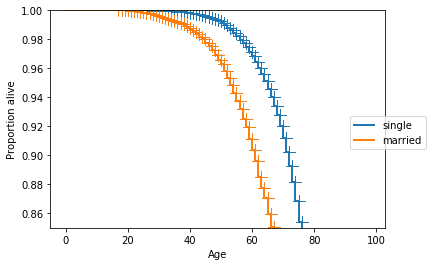

In [46]:
# Code for this plot modified from the statsmodels documentation at http://www.statsmodels.org/dev/duration.html

groups = data2.groupby("single")
ax = plt.axes()
sexes = ["single","married"]

# Fitting a survival function for each group
for group in groups:
    sf = sm.SurvfuncRight(group[1]["Longevity"], group[1]["dead"])
    sf.plot(ax)
li = ax.get_lines()
plt.figlegend((li[0], li[2]), sexes, "center right")
ax.set_ylabel("Proportion alive")
ax.set_xlabel("Age")
ax.set_autoscaley_on(False)
ax.set_ylim([.85,1])



Most people are still alive, but this may be due to extreme right-censoring.  

# Cox PH for Single

A graph is all very well, but is the difference in longevity for men and women meaningful?  We can test using the Cox PH model.

In [48]:
smf.phreg

<bound method PHReg.from_formula of <class 'statsmodels.duration.hazard_regression.PHReg'>>

In [47]:
mod = smf.phreg("Longevity ~ single", # The model
                data2, # The data
                status=data2['dead'].values # Whether values are right-censored
                ) 
rslt = mod.fit()
rslt.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: PHReg
===========================================================
Model:                  PH Reg       Sample size:    754217
Dependent variable:     Longevity    Num. events:    67383 
Ties:                   Breslow                            
-----------------------------------------------------------
       log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------
single 0.6709    0.0140 1.9560 47.9588 0.0000 1.9031 2.0104
===========================================================
Confidence intervals are for the hazard ratios
"""

#### It looks like the difference is meaningful.  The convention is to report and interpret the Hazard Ratio (HR) rather than the log HR.  According to the Cox PH, at any given age, single are 1.956 less likely to die than married, with a 95% confidence interval of 1.90 to 2.01.  This difference is statistically significant at $\alpha$ of .05 (p < .0001).  Our confidence interval is tiny because our sample is so big!

Looking from the plot to the model, you may notice that the data tell a slightly different story.  The survival rate discrepancy seems to shrink a bit after age 80.  This suggests that either we should include some additional features in the model to try and account for this discrepancy, or we should use a different modeling technique that doesn't assume that the effects of features are consistent across all values.

We can plot the predicted survival rates from the model:

In [49]:
data3=data2[(data2['Longevity'].notnull()) & (data2['female'].notnull()) 
            & (data2['dead'].notnull()) & (data2['single'].notnull())]
data3["predicted"] = rslt.predict(pred_type='surv').predicted_values

data3.head()



,Unnamed: 0,YEAR,NHISPID,AGE,SEX,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY,Longevity,dead,female,Alone,single,predicted
829402,3928174,1997,19970003080101,33,2,11,1963.0,2.0,9999.0,46.0,0.0,1,False,0,0.994091
829403,3928175,1997,19970003080102,36,1,11,1960.0,2.0,9999.0,49.0,0.0,0,False,0,0.991455
829404,3928178,1997,19970003090101,42,1,11,1954.0,1.0,1999.0,45.0,1.0,0,False,0,0.994754
829405,3928179,1997,19970003090102,52,2,11,1944.0,2.0,9999.0,65.0,0.0,1,False,0,0.948447
829407,3928182,1997,19970003100101,41,1,11,1955.0,2.0,9999.0,54.0,0.0,0,False,0,0.984089


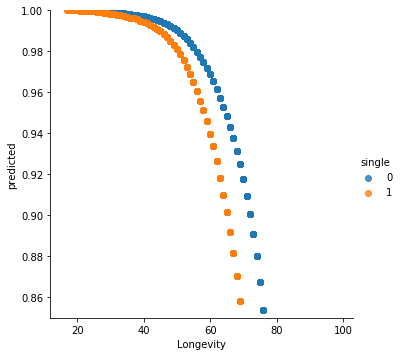

In [50]:
sns.lmplot(x="Longevity", y="predicted", hue="single", data=data3,fit_reg=False,lowess=True)
plt.ylim(.85, 1)
plt.show()